# Strategy 1: Borrowing interest rate based strategy

_Feedback from previous notebook_

Looks good, let's try Z-score model

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from tqdm.autonotebook import tqdm
import matplotlib.ticker as mtick
from common_models import Trade, StrategySummary
%matplotlib inline

/var/folders/xf/cyn6bbj5137_wg7d37wflh5r0000gq/T/ipykernel_69587/2071070054.py:5: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
df_combined = pd.read_csv("df_combined_hourly.csv")

In [3]:
df_combined = df_combined.set_index("Date")

In [4]:
df_combined = df_combined[df_combined.index >= "2023-03-01"]

In [5]:
df_combined.head(10)

,USDT,BTC,USDT_pct_change,BTC_pct_change,open,high,low,close,close_pct_change,close_pct_change_sign
Date,,,,,,,,,,
2023-03-01 00:00:00,0.000256,0.000110,NaN,NaN,23141.57,23219.99,23020.03,23101.00,NaN,NaN
2023-03-01 01:00:00,0.000256,0.000110,0.000000,0.000000,23101.00,23296.94,23075.14,23245.96,0.006275,1.0
2023-03-01 02:00:00,0.000256,0.000110,0.000000,0.000000,23245.96,23336.46,23234.20,23331.21,0.003667,1.0
2023-03-01 03:00:00,0.000256,0.000110,0.000000,0.000000,23332.57,23498.00,23305.97,23441.14,0.004712,1.0
2023-03-01 04:00:00,0.000256,0.000110,0.000000,0.000000,23440.37,23847.00,23425.44,23794.48,0.015073,1.0
2023-03-01 05:00:00,0.000256,0.000110,0.000000,0.000000,23794.48,23821.56,23631.97,23694.17,-0.004216,-1.0
2023-03-01 06:00:00,0.000164,0.000098,-0.361362,-0.109455,23695.14,23803.39,23666.00,23752.75,0.002472,1.0
2023-03-01 07:00:00,0.000164,0.000098,0.000000,0.000000,23752.75,23762.22,23681.00,23716.06,-0.001545,-1.0
2023-03-01 08:00:00,0.000168,0.000098,0.029768,0.000000,23716.06,24000.00,23681.81,23867.78,0.006397,1.0


In [6]:
def generate_indicator(interest_rate_currency: str, rolling_window: int) -> pd.Series:
    """Generate Z Score indicator
    """
    rolling = df_combined[interest_rate_currency].rolling(rolling_window)
    return ((df_combined[interest_rate_currency] - rolling.mean().shift(1)) / rolling.std(ddof=0).shift(1)).rename("indicator")

In [7]:
def generate_signal(indicator: pd.Series, threshold: float) -> pd.Series:
    """Convert indicator into signals
    """
    return (indicator > threshold).rename("signal")

In [8]:
def run_strategy(starting_capital: int, interest_rate_currency: str, rolling_window: int, threshold: float, risk_free_rate: float, verbose: bool = False):
    indicator = generate_indicator(interest_rate_currency=interest_rate_currency, rolling_window=rolling_window)
    signal = generate_signal(indicator, threshold=threshold)

    _df = df_combined.copy()
    _df = _df.join(signal).dropna(subset=["signal", "close"])

    if verbose:
        print(f"Date Range: {_df.index.min()} till {_df.index.max()}")
        print(f"No. of Trading Days: {len(_df)}")

    cash = starting_capital
    position = 0

    opening_cash = []
    opening_position = []
    closing_cash = []
    closing_position = []

    trades = []

    for id, row in _df[["signal", "close"]].iterrows():
        opening_cash.append(cash)
        opening_position.append(position)
        if row["signal"] and position == 0:
            amount = cash
            unit = amount / row["close"]
            position += unit
            cash -= amount
            trade = Trade(
                date=id,
                btc_close_price=row["close"],
                trade_type=True,
                amount=amount,
                unit=unit
            )
            if verbose:
                print(trade)
            trades.append(trade)
        elif (not row["signal"]) and position > 0:
            unit = position
            amount = unit * row["close"]
            position -= unit
            cash += amount
            trade = Trade(
                date=id,
                btc_close_price=row["close"],
                trade_type=False,
                amount=amount,
                unit=unit
            )
            if verbose:
                print(trade)
            trades.append(trade)
        closing_cash.append(cash)
        closing_position.append(position)

    
    _df["opening_cash"] = opening_cash
    _df["opening_position"] = opening_position
    _df["closing_cash"] = closing_cash
    _df["closing_position"] = closing_position
    
    _df["closing_value"] = _df["closing_cash"] + _df["closing_position"] * _df["close"]
    _df["return"] = _df["closing_value"].pct_change()
    _df["excess_return"] = _df["return"] - risk_free_rate
    _df["drawdown_pct"] = 1 - _df["closing_value"] / _df["closing_value"].expanding().max()
    _df["drawdown_period"] = _df["drawdown_pct"].groupby((_df["drawdown_pct"] == 0).cumsum()).cumcount()

    perf = StrategySummary(
        start_date=_df.index[0],
        end_date=_df.index[-1],
        starting_capital=starting_capital,
        trades=trades,
        total_pnl=_df["closing_value"].iloc[-1] - starting_capital,
        total_pnl_pct=_df["closing_value"].iloc[-1] / starting_capital - 1,
        sharpe_ratio=(_df['excess_return'].mean() / _df['excess_return'].std()) if len(trades) > 0 else None,
        days_in_market=(_df["closing_position"] > 0).sum(),
        days_in_market_pct=(_df["closing_position"] > 0).mean(),
        portfolio_value_timeline=_df["closing_value"],
        max_drawdown_pct=_df["drawdown_pct"].max(),
        max_drawdown_period=_df["drawdown_period"].max(),
        drawdown_period_timeline=_df["drawdown_period"],
        watermark_timeline=_df["drawdown_pct"]
    )
    return perf

In [9]:
time_period = 365 * 24 # 1Y to hours
risk_free_rate = .0494 / time_period # 1Y T Bill

In [10]:
look_back_period_limit = len(df_combined) // 10
look_back_period_limit

705

In [11]:
_ = 10
windows = []
while _ < look_back_period_limit:
    windows.append(_)
    _ *= 2
windows

[10, 20, 40, 80, 160, 320, 640]

In [12]:
thresholds = [0, 1, 2, 4, 8, 16, 32]
# thresholds = np.linspace(0,5,11)

df_sr = []
for window in tqdm(windows):
    df_sr.append(
        [
            run_strategy(
                starting_capital=100,
                interest_rate_currency="USDT",
                rolling_window=window,
                threshold=threshold,
                risk_free_rate=risk_free_rate
            ).sharpe_ratio
            for threshold in thresholds
        ]
    )
df_sr = pd.DataFrame(df_sr, index=windows, columns=thresholds) * np.sqrt(time_period)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.49it/s]


Text(95.72222222222221, 0.5, 'Rolling Window (Hour)')

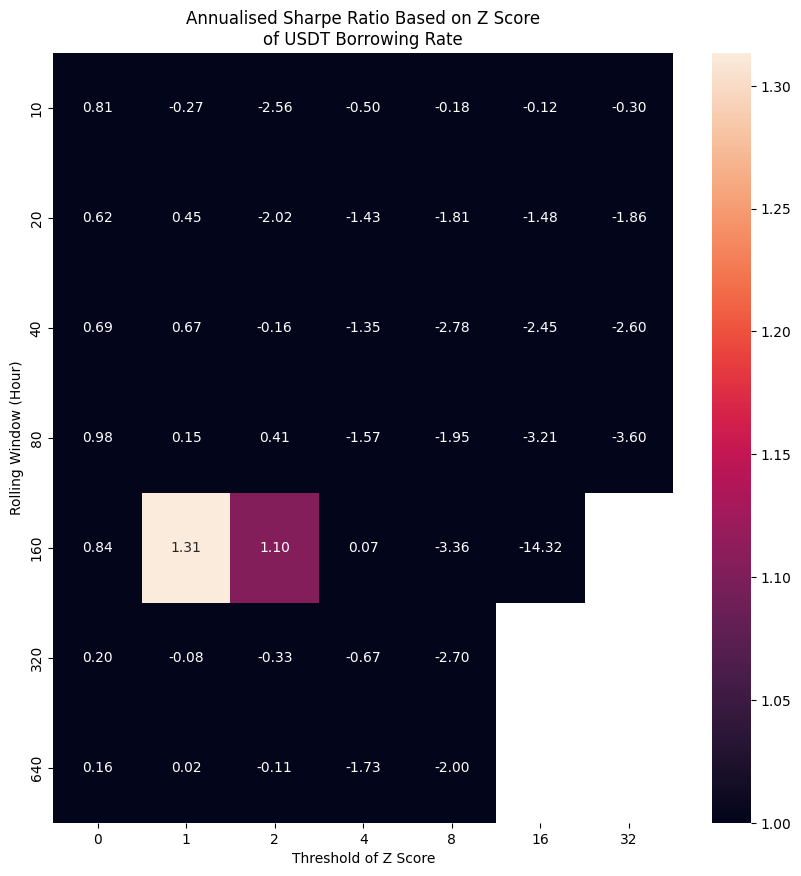

In [13]:
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(df_sr.astype(float), annot=True, fmt=".2f", ax=ax, vmin=1, vmax=df_sr.max().max(), robust=True)
ax.set_title("Annualised Sharpe Ratio Based on Z Score\nof USDT Borrowing Rate")
ax.set_xlabel("Threshold of Z Score")
ax.set_ylabel("Rolling Window (Hour)")

In [14]:
thresholds = [0, 1, 2, 4, 8, 16, 32]
# thresholds = np.linspace(0,5,11)

df_sr = []
for window in tqdm(windows):
    df_sr.append(
        [
            run_strategy(
                starting_capital=100,
                interest_rate_currency="BTC",
                rolling_window=window,
                threshold=threshold,
                risk_free_rate=risk_free_rate
            ).sharpe_ratio
            for threshold in thresholds
        ]
    )
df_sr = pd.DataFrame(df_sr, index=windows, columns=thresholds) * np.sqrt(time_period)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.52it/s]


Text(95.72222222222221, 0.5, 'Rolling Window (Hour)')

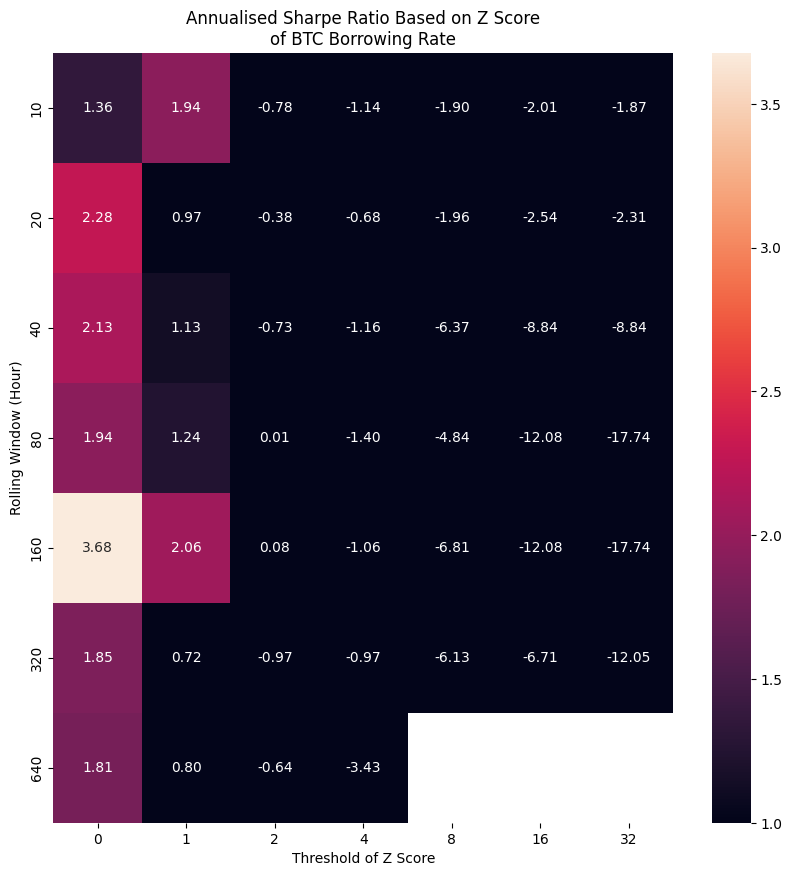

In [15]:
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(df_sr.astype(float), annot=True, fmt=".2f", ax=ax, vmin=1, vmax=df_sr.max().max(), robust=True)
ax.set_title("Annualised Sharpe Ratio Based on Z Score\nof BTC Borrowing Rate")
ax.set_xlabel("Threshold of Z Score")
ax.set_ylabel("Rolling Window (Hour)")

In [16]:
thresholds = [0, .1, .2, .4, .8, 1.6, 3.2]
# thresholds = np.linspace(0,5,11)

df_sr = []
for window in tqdm(windows):
    df_sr.append(
        [
            run_strategy(
                starting_capital=100,
                interest_rate_currency="BTC",
                rolling_window=window,
                threshold=threshold,
                risk_free_rate=risk_free_rate
            ).sharpe_ratio
            for threshold in thresholds
        ]
    )
df_sr = pd.DataFrame(df_sr, index=windows, columns=thresholds) * np.sqrt(time_period)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.50it/s]


Text(95.72222222222221, 0.5, 'Rolling Window (Hour)')

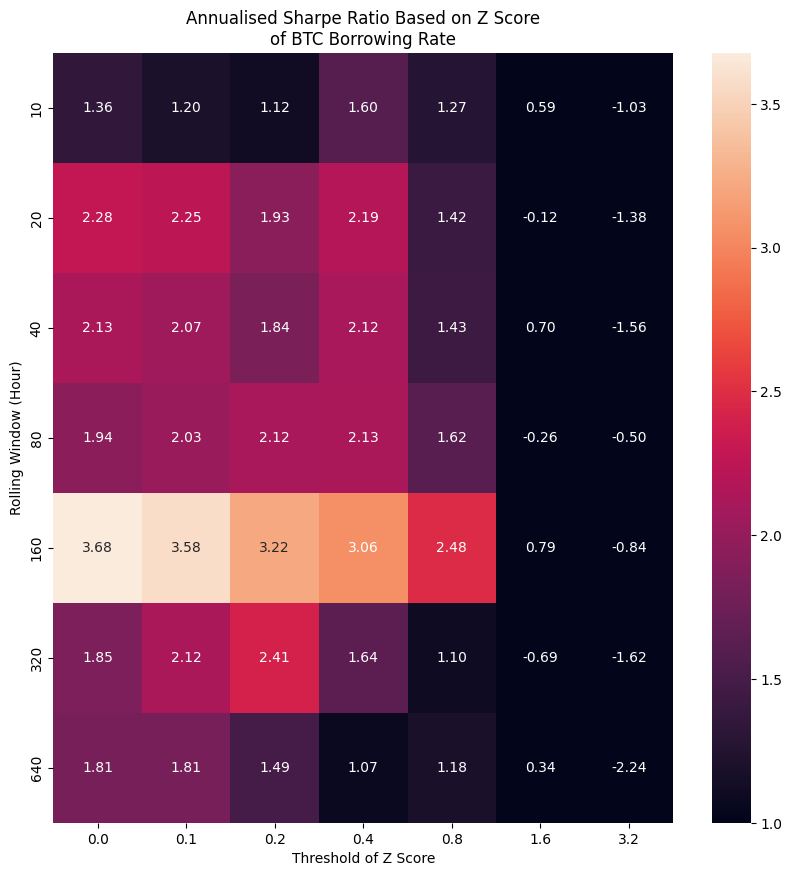

In [17]:
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(df_sr.astype(float), annot=True, fmt=".2f", ax=ax, vmin=1, vmax=df_sr.max().max(), robust=True)
ax.set_title("Annualised Sharpe Ratio Based on Z Score\nof BTC Borrowing Rate")
ax.set_xlabel("Threshold of Z Score")
ax.set_ylabel("Rolling Window (Hour)")

In [18]:
parameters = dict(
    starting_capital=100,
    interest_rate_currency="BTC",
    rolling_window=160,
    threshold=0.0,
    risk_free_rate=risk_free_rate
)
result = run_strategy(
    **parameters
)

Text(0.5, 1.0, "Equity Curve\nStart Date: 2023-03-01 00:00:00\nEnd Date: 2023-12-19 22:00:00\nNo. Trade: 282\nPnL: 122.88%\nAnnualised Sharpe Ratio: 3.68\nMax Drawdown: 7.73%\nMax Drawdown Period: 1,604\nFull Parameters:{'starting_capital': 100, 'interest_rate_currency': 'BTC', 'rolling_window': 160, 'threshold': 0.0, 'risk_free_rate': 5.639269406392694e-06}")

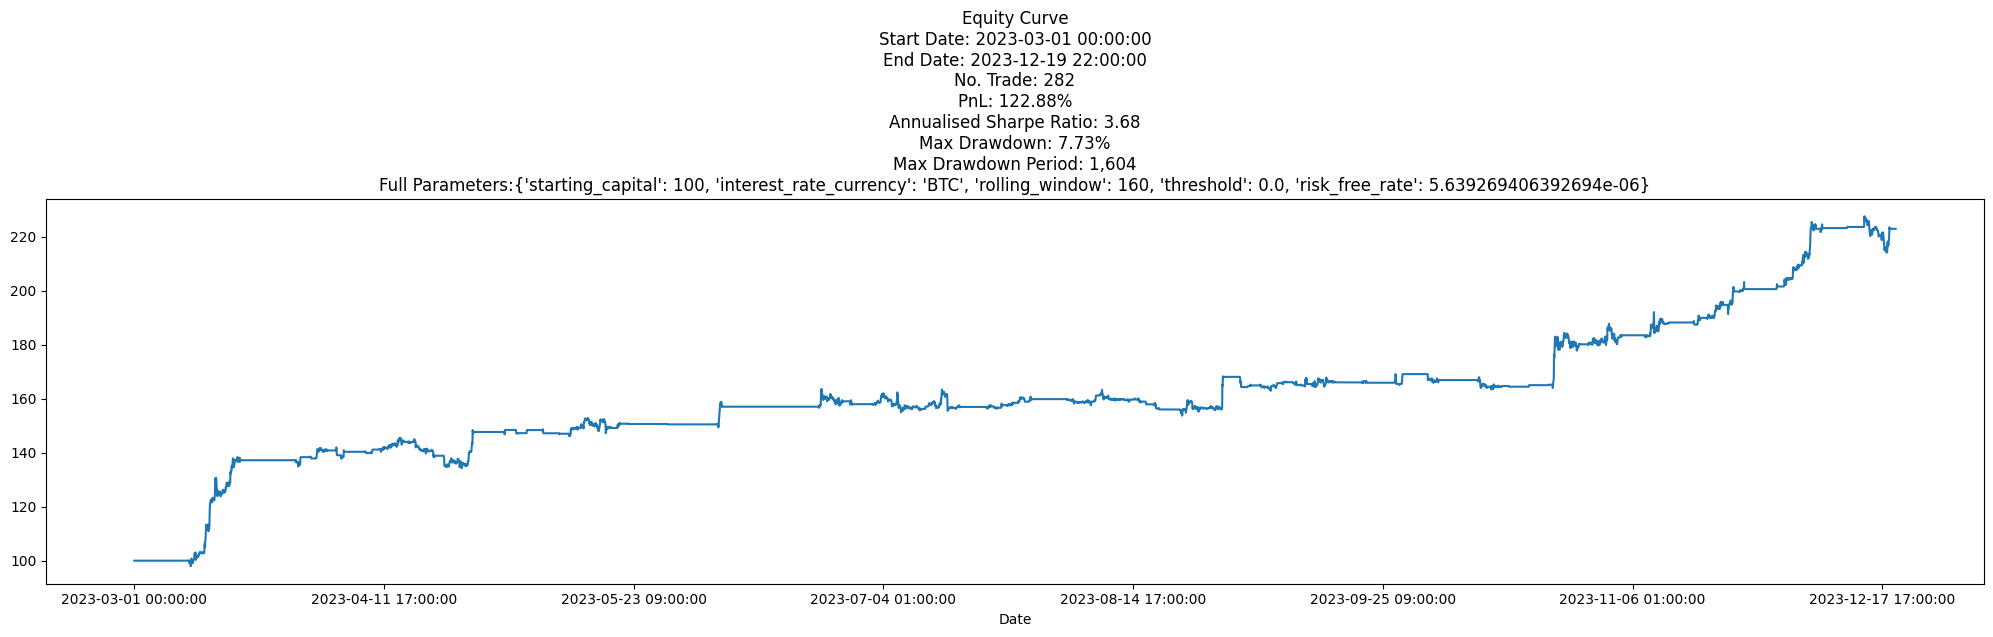

In [19]:
ax = result.plot_equity_curve()
ax.set_title(f"""Equity Curve
Start Date: {result.start_date}
End Date: {result.end_date}
No. Trade: {len(result.trades):,g}
PnL: {result.total_pnl_pct:.2%}
Annualised Sharpe Ratio: {result.sharpe_ratio * np.sqrt(time_period):.2f}
Max Drawdown: {result.max_drawdown_pct:.2%}
Max Drawdown Period: {result.max_drawdown_period:,g}
Full Parameters:{parameters}""")

In [20]:
# Get all combinations over SR 1.9

combinations = []
for threshold in df_sr.columns:
    combinations.extend([(_, threshold) for _ in df_sr.index[df_sr[threshold] > 1.9]])

In [21]:
performance = []
for window, threshold in combinations:
    performance.append(
        run_strategy(
            starting_capital=100,
            interest_rate_currency="BTC",
            rolling_window=window,
            threshold=threshold,
            risk_free_rate=risk_free_rate
        )
    )

In [22]:
pd.set_option('display.max_rows', 100)
df_performance = pd.DataFrame(
    [
        {
            "pnl_pct": p.total_pnl_pct,
            "sharpe_ratio": p.sharpe_ratio * np.sqrt(time_period),
            "max_drawdown_pct": p.max_drawdown_pct,
            "max_drawdown_period": p.max_drawdown_period,
            "trades": len(p.trades)
        } for p in performance
    ],
    index=combinations
).sort_values(by=["sharpe_ratio"], ascending=False)

In [23]:
df_performance

,pnl_pct,sharpe_ratio,max_drawdown_pct,max_drawdown_period,trades
"(160, 0.0)",1.228790,3.677622,0.077282,1604,282
"(160, 0.1)",1.136668,3.576070,0.061906,1325,274
"(160, 0.2)",0.934397,3.218912,0.055990,1325,256
"(160, 0.4)",0.762459,3.059263,0.112302,2664,254
"(160, 0.8)",0.471086,2.475791,0.100231,3087,220
"(320, 0.2)",0.563310,2.411378,0.069125,1329,174
"(20, 0.0)",0.601748,2.281576,0.135130,4618,599
"(20, 0.1)",0.576750,2.248538,0.137636,4618,591
"(20, 0.4)",0.509339,2.190422,0.096644,4618,577
"(40, 0.0)",0.569785,2.131249,0.128649,4617,491
